Found cached dataset sms_spam (C:/Users/Kasten/.cache/huggingface/datasets/sms_spam/plain_text/1.0.0/53f051d3b5f62d99d61792c91acefe4f1577ad3e4c216fb0ad39e30b9f20019c)


  0%|          | 0/1 [00:00<?, ?it/s]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kasten\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Loading cached processed dataset at C:\Users\Kasten\.cache\huggingface\datasets\sms_spam\plain_text\1.0.0\53f051d3b5f62d99d61792c91acefe4f1577ad3e4c216fb0ad39e30b9f20019c\cache-742950cb3fee7e83.arrow
Loading cached processed dataset at C:\Users\Kasten\.cache\huggingface\datasets\sms_spam\plain_text\1.0.0\53f051d3b5f62d99d61792c91acefe4f1577ad3e4c216fb0ad39e30b9f20019c\cache-2989291ae7fc36ad.arrow
Loading cached processed dataset at C:\Users\Kasten\.cache\huggingface\datasets\sms_spam\plain_text\1.0.0\53f051d3b5f62d99d61792c91acefe4f1577ad3e4c216fb0ad39e30b9f20019c\cache-3289f25c85eb04a5.arrow


Dataloader:



100%|██████████| 7570/7570 [01:17<00:00, 97.62it/s] 


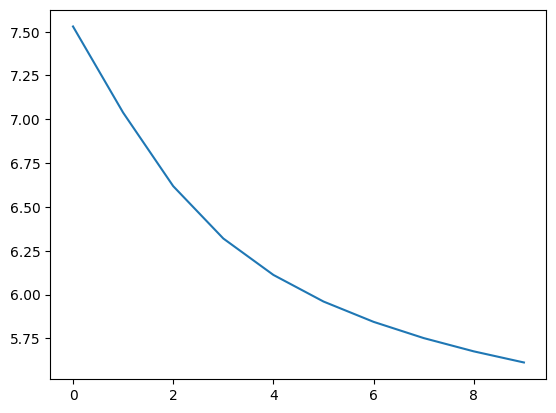

Last Loss Value: 5.6121862970853575

mom ['die', 'rememb', 'rs', 'lol', 'shes', 'aight', 'big', 'yo', 'turn', 'move'] 

teacher ['happend', 'callsmessagesmiss', 'buzi', 'easier', 'aathilov', 'oreo', 'oic', 'deari', 'tirupur', 'max'] 

fun ['left', 'miss', 'much', 'great', 'hope', 'shit', 'like', 'messag', 'would', 'that'] 



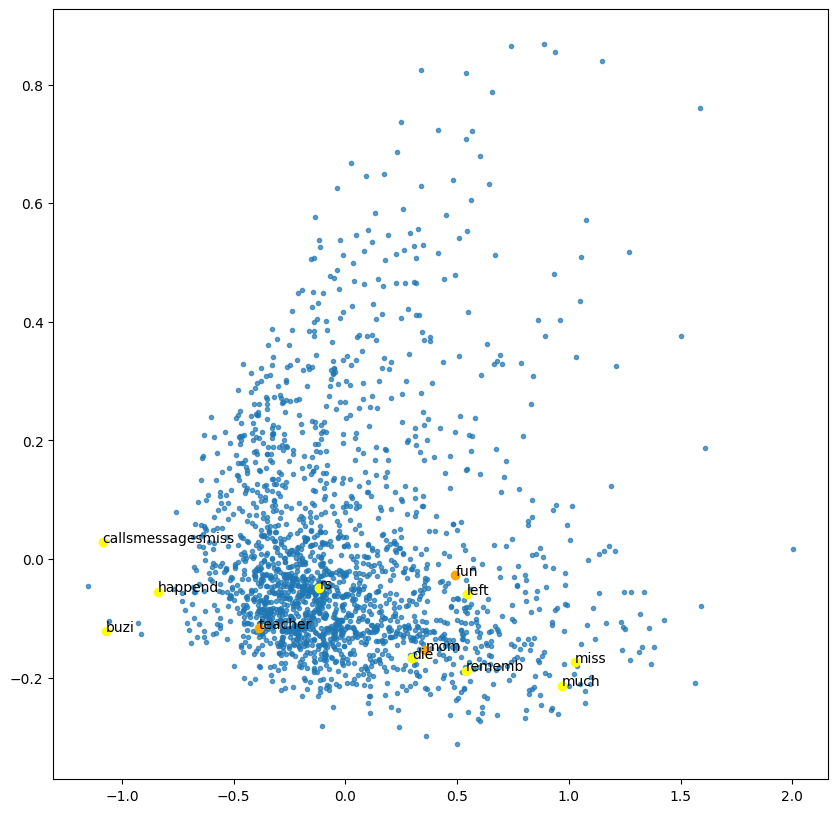

In [1]:
from word2vec import Word2Vec, Word2VecDataset
from torch.utils.data import DataLoader
import datasets


n_vocab = 2000
dataset = Word2VecDataset(datasets.load_dataset('sms_spam'), vocab_size=n_vocab)                   
dataloader = DataLoader(dataset=dataset, 
                        batch_size=2**8,
                        shuffle=True,
                        num_workers=0)

print("Dataloader:\n")
print(dataloader)

EMBED_SIZE = 200
LR = 3e-4
EPOCHS = 10


model = Word2Vec(n_vocab, EMBED_SIZE)
model.train(dataloader, EPOCHS, LR)
model.plot_running_loss()

# Print 10 most similar words for each word in 'tokens' list
tokens = ['mom', 'teacher', 'fun']
for word in tokens:
    print(word, [t[1] for t in model.get_k_similar_words(word=word, dataset=dataset)], "\n")

# Visualize latent vectors
#model.visualize_latent_vectors()
model.visualize_latent_vectors(annotate=True, dataset=dataset, tokens=tokens)
 


In [2]:
import gensim.downloader
from gensim.models import KeyedVectors

try:
    word2vec_vectors =  KeyedVectors.load_word2vec_format('word2vec-google-news-300.bin', binary=True)
except:
    word2vec_vectors = gensim.downloader.load('word2vec-google-news-300')
    word2vec_vectors.save_word2vec_format('word2vec-google-news-300.bin', binary=True)

ModuleNotFoundError: No module named 'gensim'

In [ ]:
from pandas import DataFrame
vocab_google_news = DataFrame(word2vec_vectors.index_to_key).rename({0:'word'},axis=1)


In [ ]:
# get all rows that are in dataset.vocab
filtered_vocab = vocab_google_news[vocab_google_news.word.isin(dataset.vocab)]

print("SMS-Spam Vocab(Number of Tokens): " + str(n_vocab))
print("Google_News Vocab(Number of Tokens): " + str(len(vocab_google_news)))
print("Filtered Google_News Vocab(Number of Tokens that are in Both Vocabs): " + str(len(filtered_vocab)))
print("Vocab Wights, that need to be randomly initialised: " + str(n_vocab - len(filtered_vocab)))

# get only the vectors for the filtered vocab
filtered_vectors = word2vec_vectors[filtered_vocab.index]

# add the vectors to the dataframe
filtered_vocab = filtered_vocab.assign(vectors=filtered_vectors.tolist())


import pandas as pd
import numpy as np
token_to_vector = DataFrame(pd.merge(left=DataFrame(dataset.vocab).rename({0:'word'},axis=1), right=filtered_vocab, left_on='word', right_on='word', how='left')   .set_index('word').apply(
    lambda x: x.vectors if isinstance(x.vectors, list) else np.random.randint(low=0, high=1, size=300), axis=1#np.zeros(300), axis=1
)).to_dict()[0]

for pretrained_model_keys, spam_ham_vocab_keys in zip(token_to_vector.keys(), dataset.tok2id):
    assert(pretrained_model_keys == spam_ham_vocab_keys)



pretrained_weights = np.array(list(token_to_vector.values()))

# use pca to reduce embedding to 200 dimensions
from sklearn.decomposition import PCA
pretrained_weights = PCA(n_components=200).fit_transform(pretrained_weights)

model.set_wordvecs(pretrained_weights)
model.visualize_latent_vectors(annotate=True, dataset=dataset, tokens=tokens)



In [ ]:
model.train(dataloader, EPOCHS, LR)
model.plot_running_loss()
model.visualize_latent_vectors(annotate=True, dataset=dataset, tokens=tokens)